[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Neuvork/Engeneering-thesis/blob/master/results.ipynb)

In [6]:
! git clone https://<username>:<password>@github.com/Neuvork/Engeneeringthesis.git --single-branch --branch cmaes

fatal: destination path 'Engeneeringthesis' already exists and is not an empty directory.


In [1]:
#DOPISAC CMA
#ZROBIC REKURENCYJNY ES
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import time
from IPython.display import clear_output
import copy
import cupy as cp
import tensorflow_datasets as tfds
import tensorflow as tf
from Engeneeringthesis.sigmas import Sigmas_Neural_Network
from Engeneeringthesis.NeuralNetwork import Neural_Network
from Engeneeringthesis.Cma_es import CMA_ES
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist

In [2]:
!nvidia-smi

Wed Oct 14 21:29:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
def cuda_memory_clear():
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()          

In [4]:
no_debug = 1
basic_debug_mode = 2
super_debug_mode = 3
only_interesting = 5
DEBUG_MODE = only_interesting

In [5]:
train_ds_mnist = tfds.load("mnist", split = "train", shuffle_files=True, batch_size=-1)
test_ds_mnist = tfds.load("mnist", split = "test", shuffle_files=True, batch_size=-1)

train_ds_mnist = tfds.as_numpy(train_ds_mnist)
test_ds_mnist = tfds.as_numpy(test_ds_mnist)

train_ds_mnist = {"image" : cp.array(train_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(train_ds_mnist["label"]) }
test_ds_mnist = {"image" : cp.array(test_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(test_ds_mnist["label"]) }

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0245 - val_loss: 0.0095
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.004

In [10]:
encoded_imgs = autoencoder.encoder(x_train).numpy()
encoded_imgs_test = autoencoder.encoder(x_test).numpy()

In [11]:
train_ds_mnist = {"image" : cp.array(encoded_imgs.reshape(60000,8,8), dtype=cp.float32), "label" : y_train }
test_ds_mnist = {"image" : cp.array(encoded_imgs_test.reshape(10000,8,8), dtype=cp.float32), "label" : y_test }

In [12]:
def evaluate_population(population, train_ds):
    create_input_time = 0
    preds_time = 0
    points_count_time = 0
    j  = 0
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_START")
    #scores = np.zeros(population.layers[0][1].shape[0], dtype = np.uint32)
    scores = cp.zeros(population.population_size, dtype = cp.uint32)
    for image, label in zip(cp.array(train_ds['image']), cp.array(train_ds['label'])):
        start = time.time()
        image = image.flatten()
        create_input_time += time.time() - start
        start = time.time()
        preds = population.forward(image)
        preds_time += time.time() - start
        start = time.time()
        #scores += cp.asnumpy(preds == label)
        scores += preds == label
        points_count_time += time.time() - start
        j += 1
      
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_STOP", "create_input_time: ", create_input_time, "preds_time:", preds_time,
          "points_count_time: ", points_count_time, "\n best result: ", np.max(cp.asnumpy( scores)),
          "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores))) 
    if DEBUG_MODE % only_interesting == 0:
      print("best result: ", np.max(cp.asnumpy( scores)), "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores)))

    return scores

In [13]:
!nvidia-smi

Wed Oct 14 21:29:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W /  70W |   1039MiB / 15079MiB |     14%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
POPULATION_SIZE = 2048
#input size do zmiany
population = Neural_Network(POPULATION_SIZE,  (8*8, 1, 1), [['linear', 10, [1.,1.]]])
sigmas = Sigmas_Neural_Network(POPULATION_SIZE,  (8*8, 1, 1), [['linear', 10, [1.,1.]]])

__compute_dimensionality start
__compute_dimensionality stop  640


In [15]:
classifier = CMA_ES(population, 5, evaluate_population)

____allocated
('matrix', 'covariance')
('population', 'population')
('number', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')
['vector', 'mean diff']


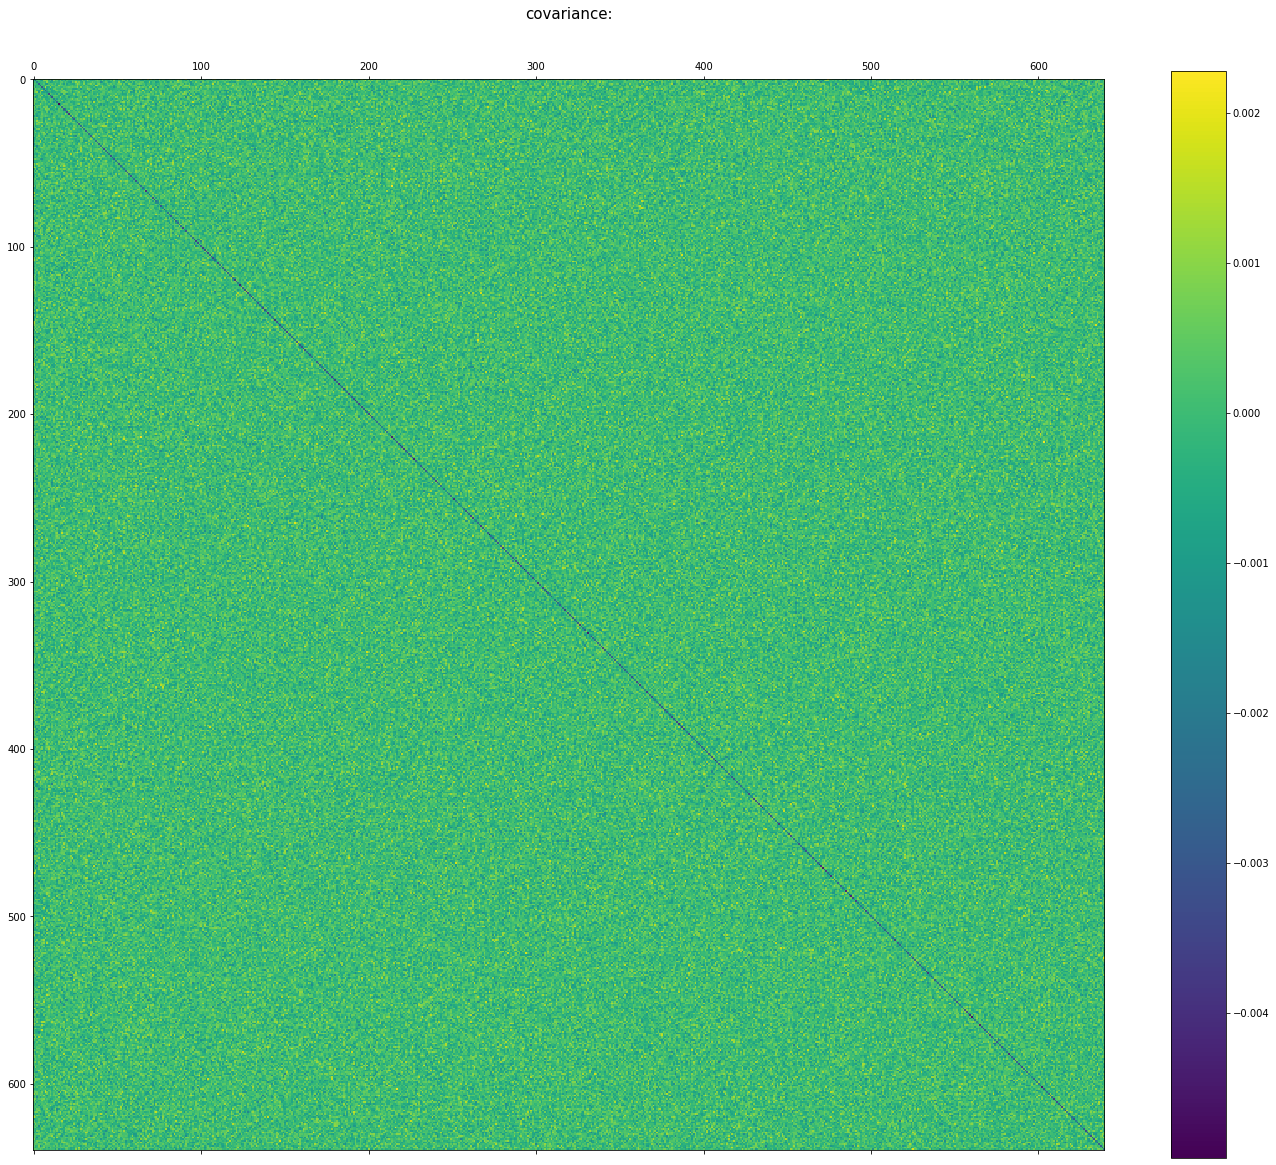

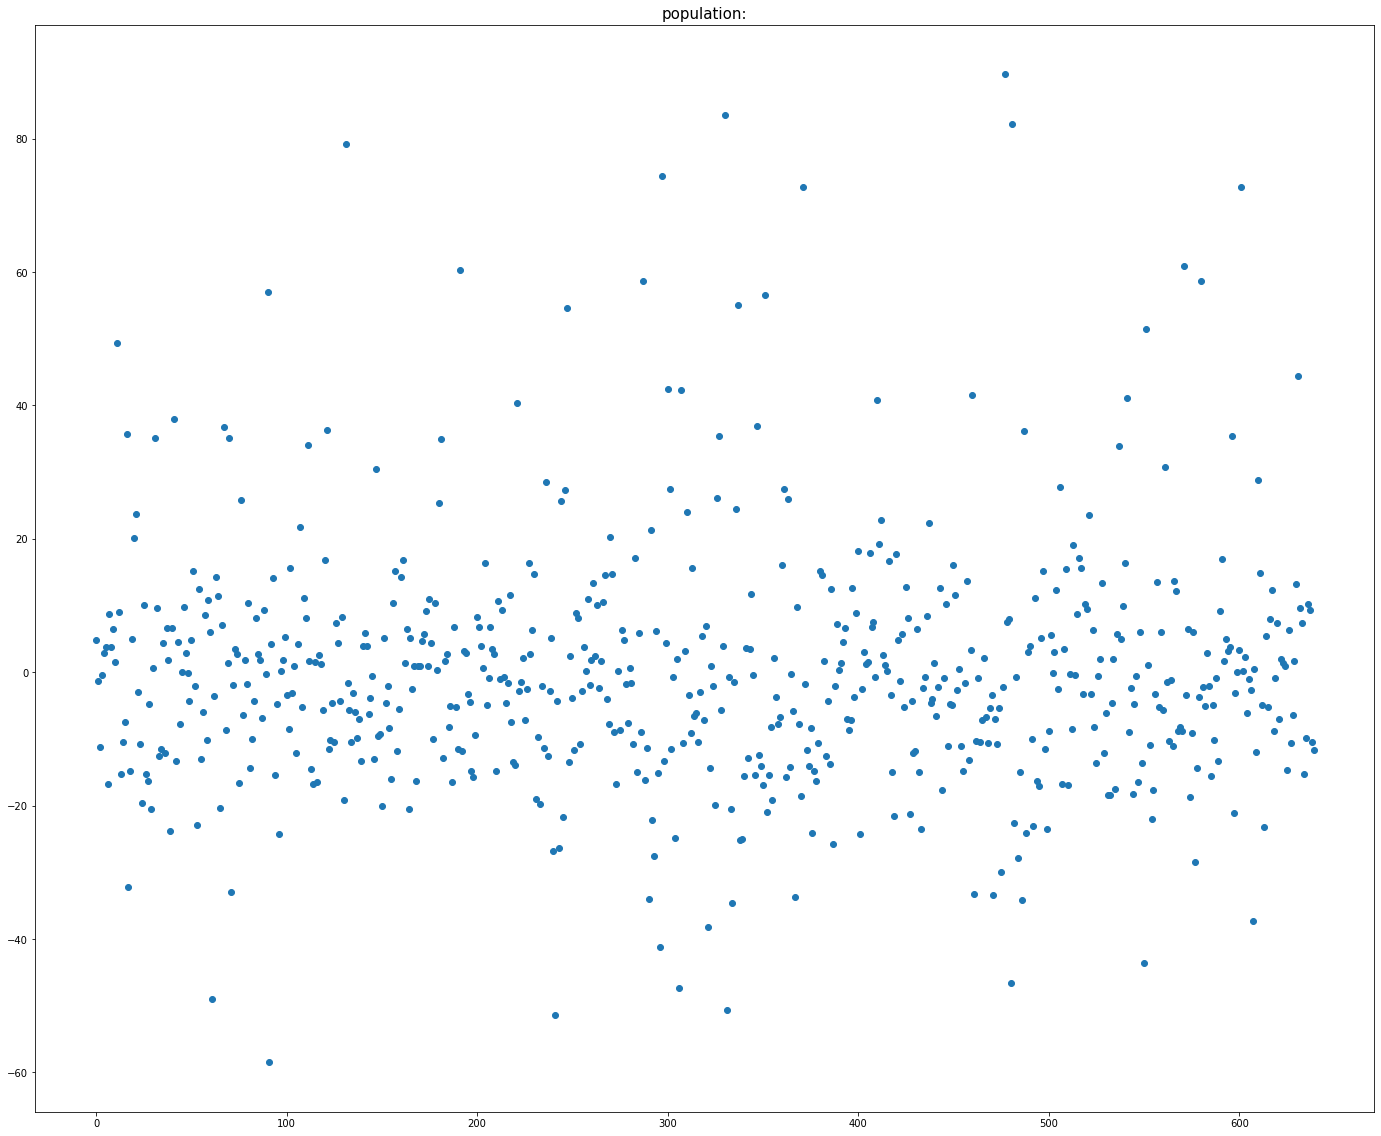

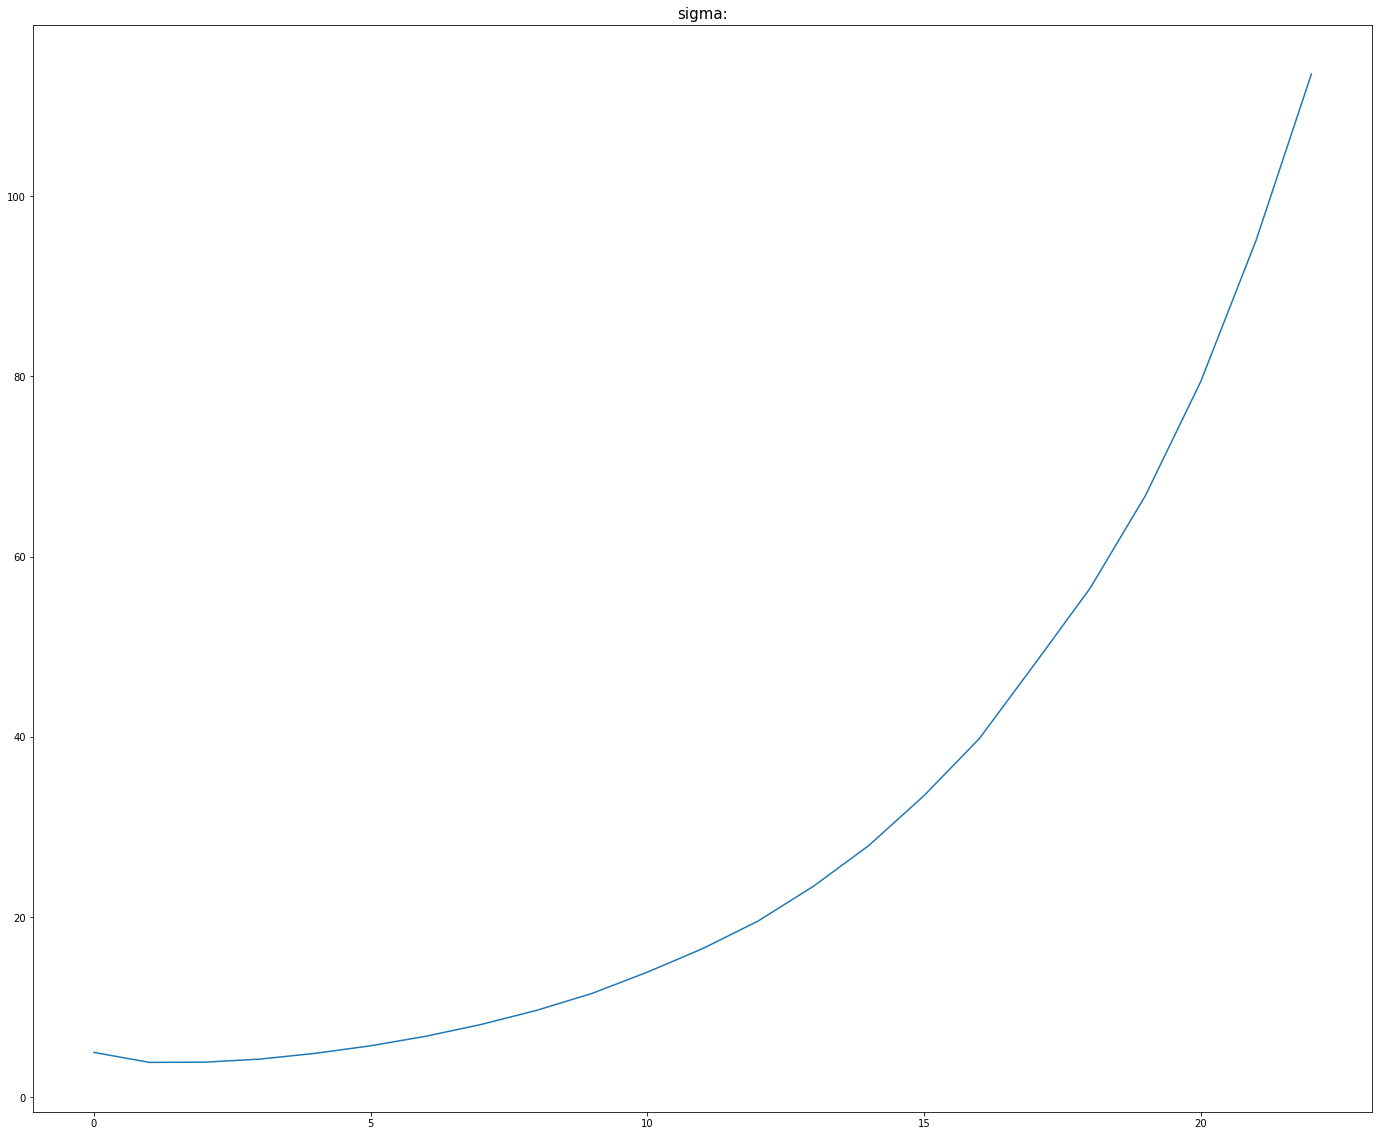

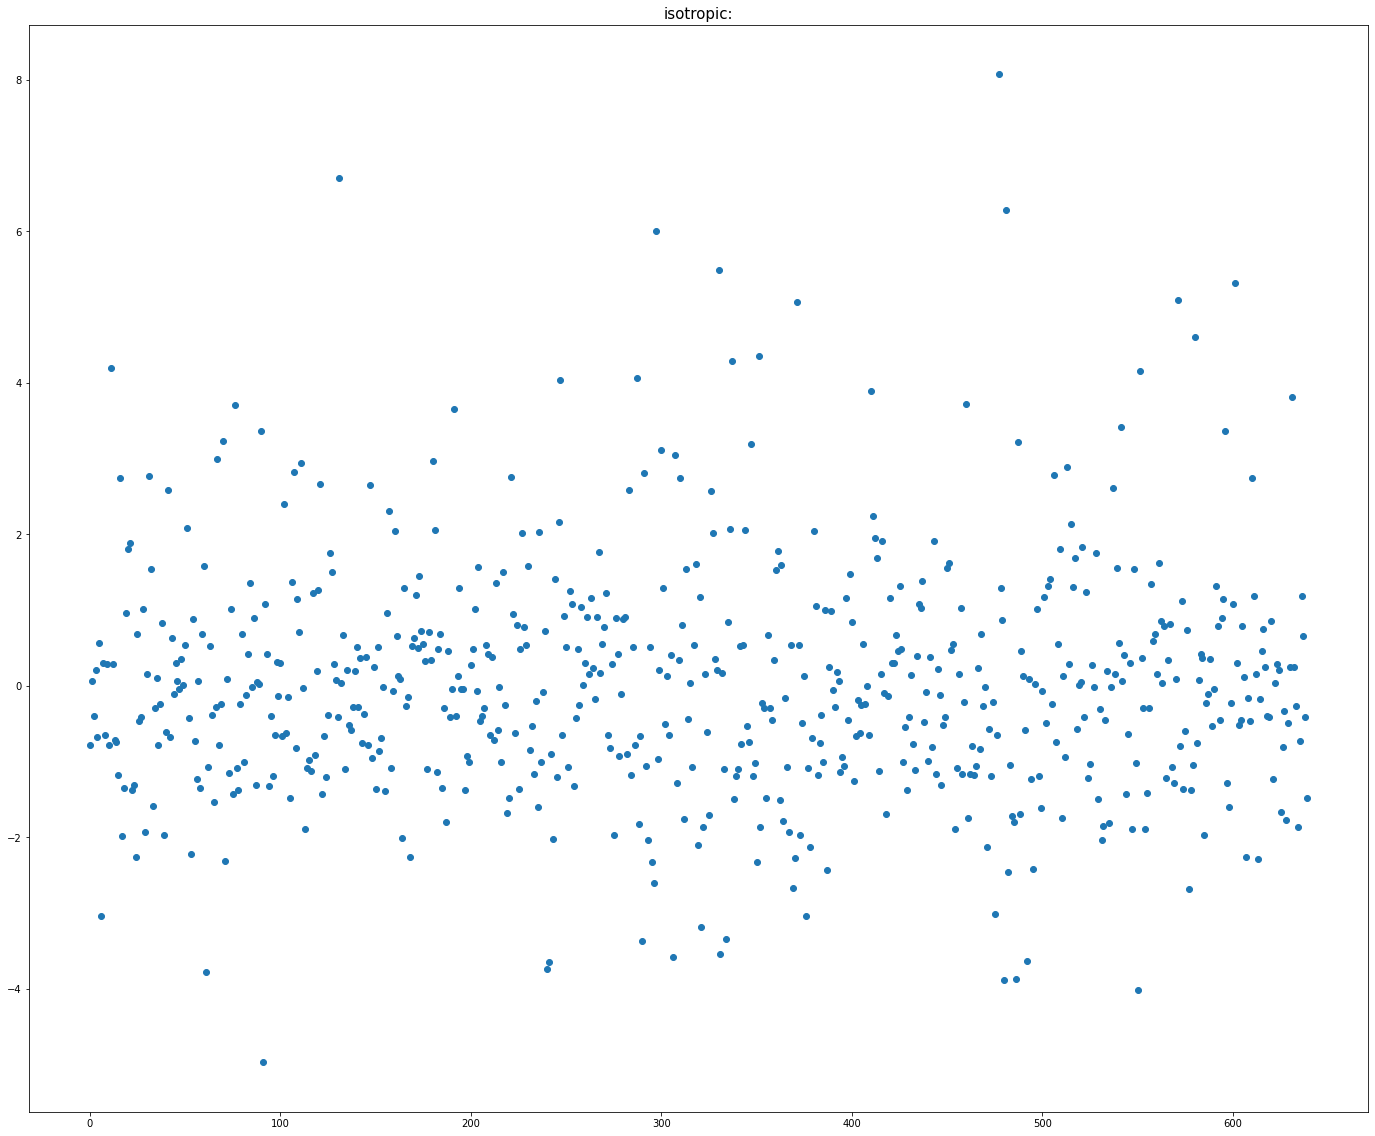

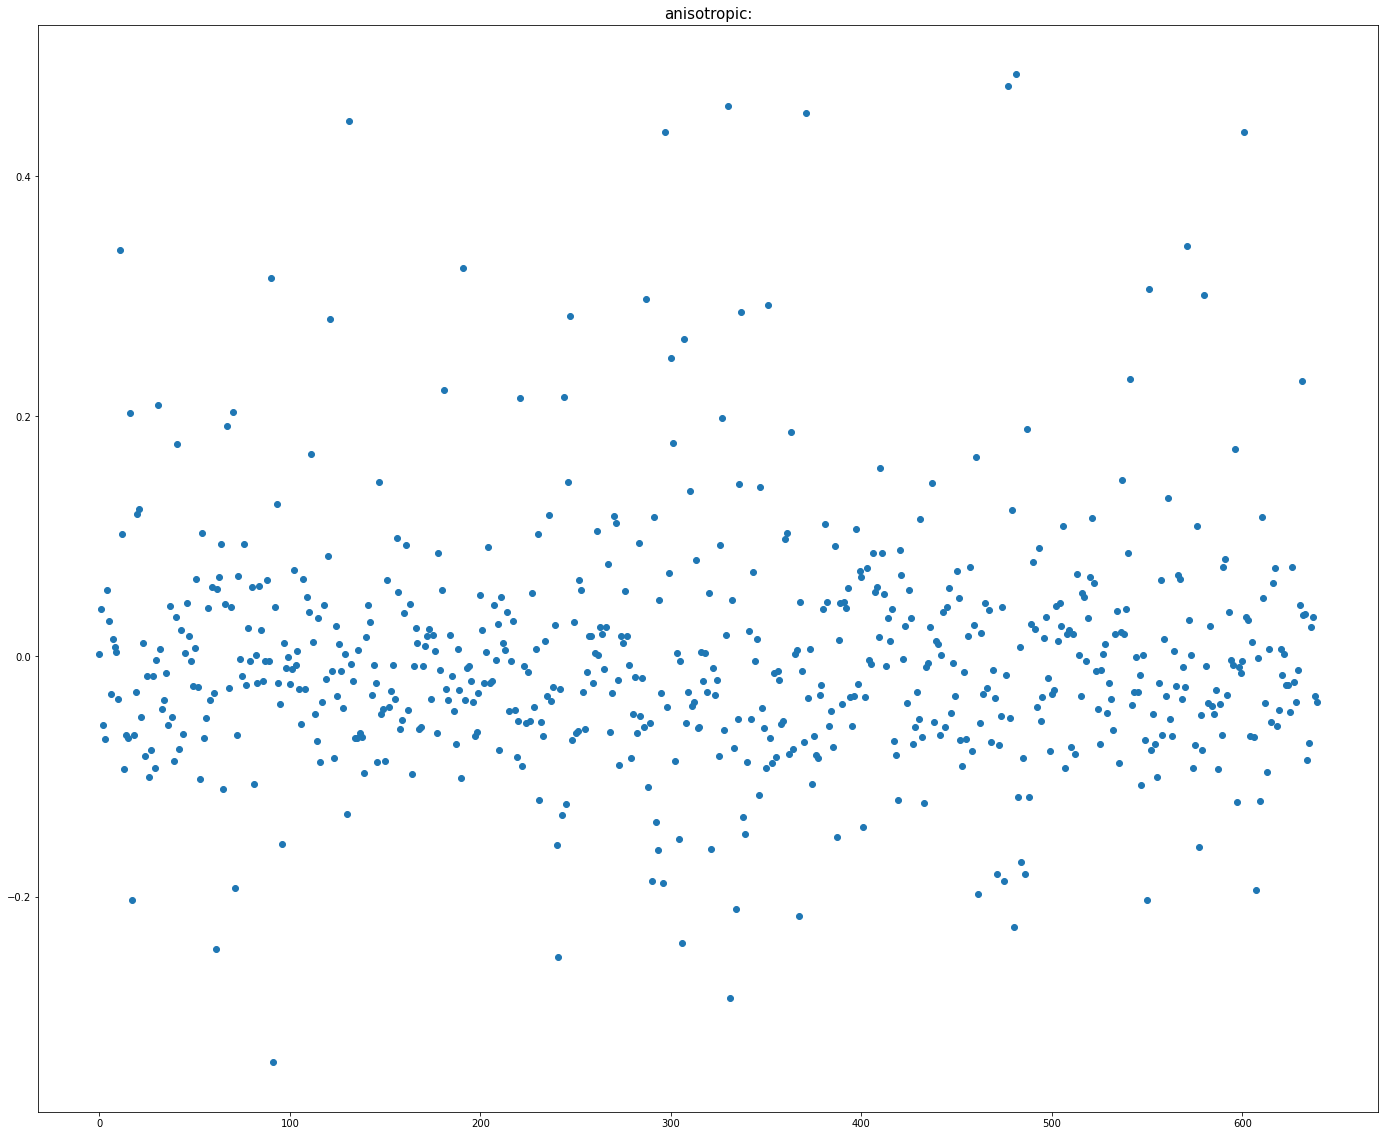

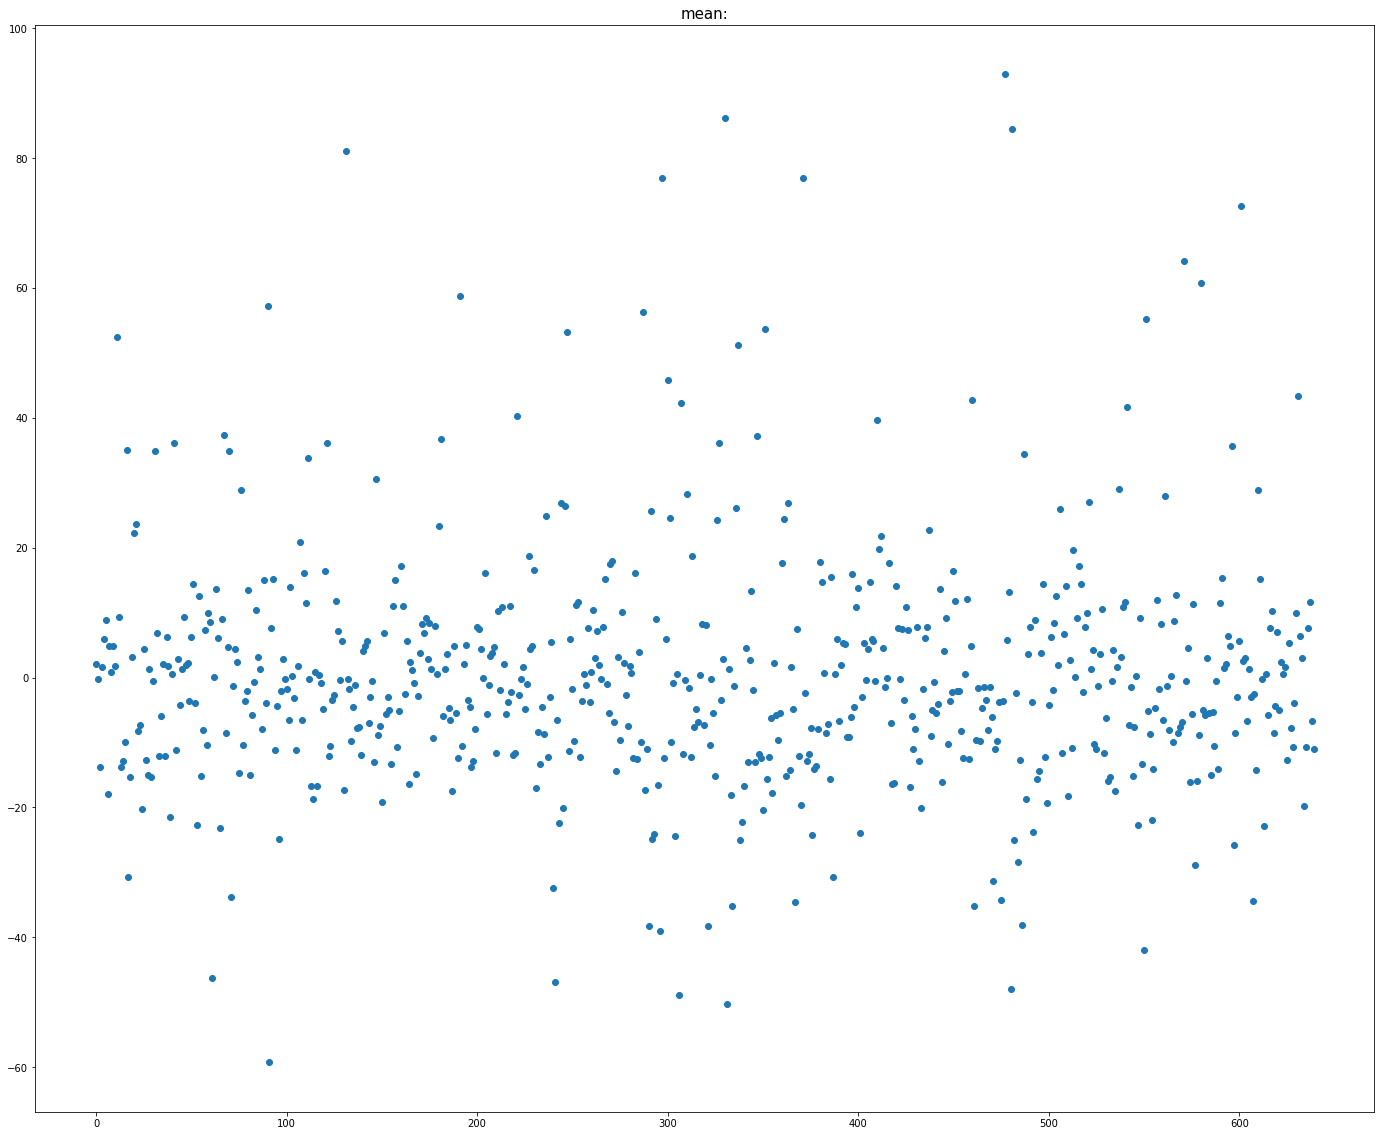

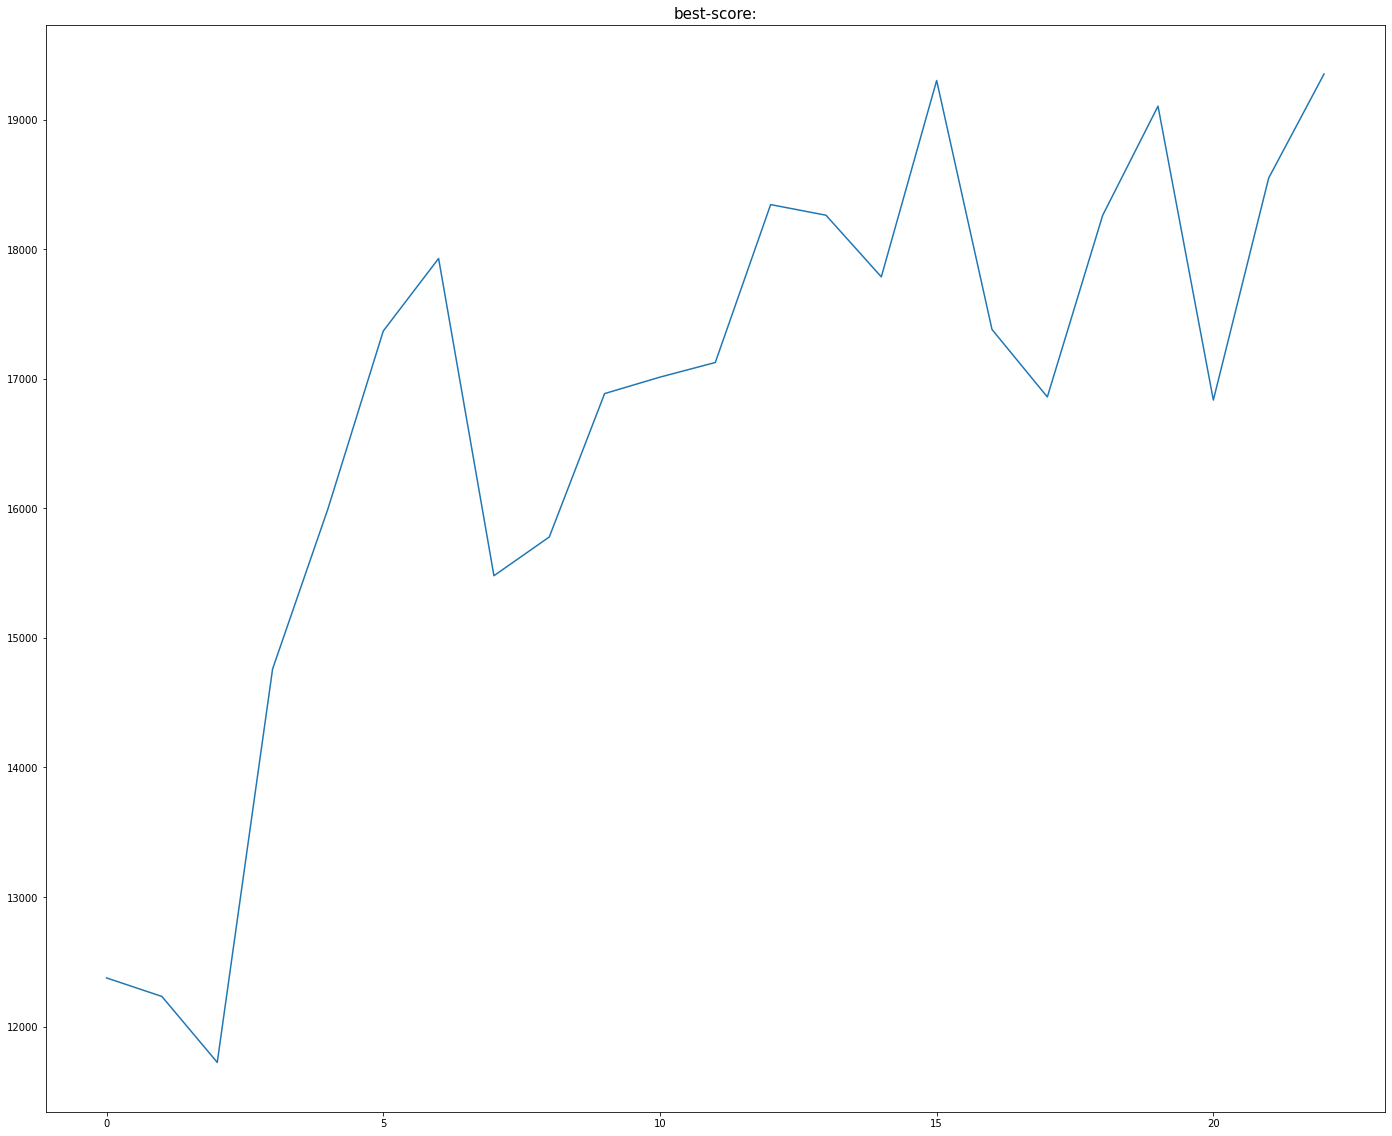

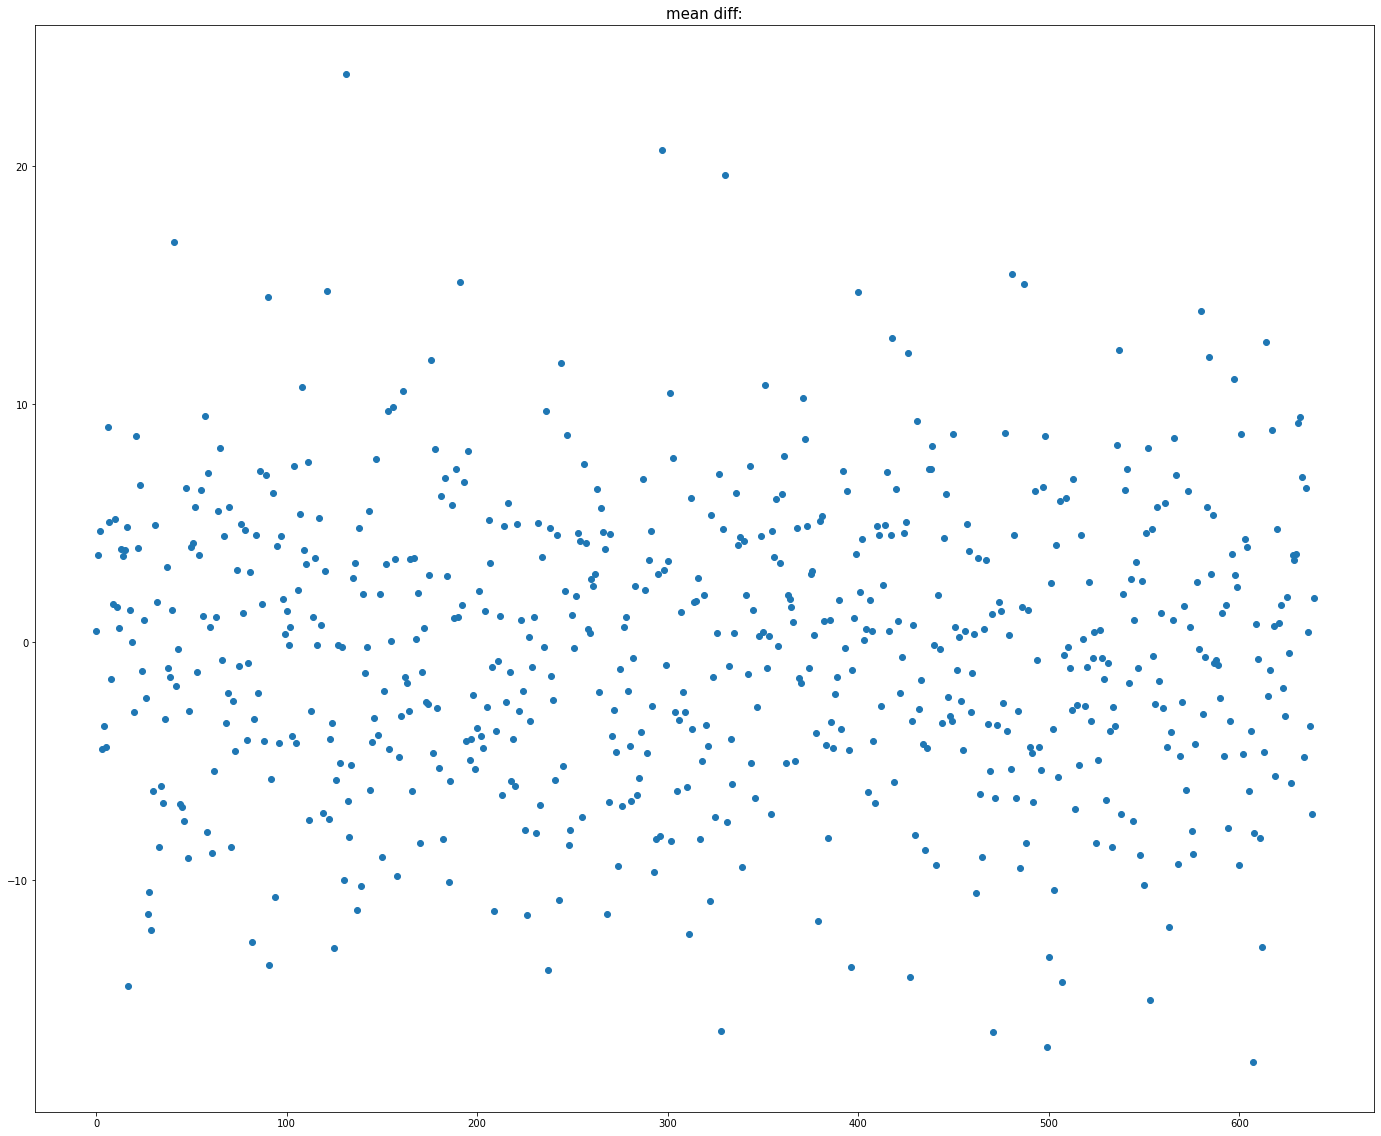

__update isotropic start, self.isotropic.shape =  (640,)
__update isotropic stop, self.isotropic.shape =  (640,)
__compute_cs start
__compute_cs end
___indicator_function start  39.75296794782665 1.5
___indicator_function stop  1
__update_anisotropic start
___indicator_function start  39.75296794782665 1.5
___indicator_function stop  1
__update_anisotropic stop
__update_covariance_matrix start
___sum_for_covariance_matrix_update start
___sum_for_covariance_matrix_update stop: 
___sum_for_covariance_matrix_update start
___sum_for_covariance_matrix_update stop: 
__shapeOfALL (640, 640) (640, 640) (640, 640) (640, 640)
__update_covariance_matrix stop
_update_sigma start
_update_sigma stop
__sample start
_total_bytes_before 234880000
_total_bytes_after 234880000
DEBUG_STAMP
_total_bytes_before 234880000
_total_bytes_after 234880000
_total_bytes_before 234880000
_total_bytes_after 234880000
_total_bytes_before 234880000
_total_bytes_after 234880000
_total_bytes_before 234880000
_total_bytes

In [ ]:
classifier.fit(train_ds_mnist, 1024, 2048, 500)